In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Constants
IMG_SIZE = (320, 320)  # Updated to match MURA paper
BATCH_SIZE = 32
EPOCHS = 40
DATA_PATH = "./MURA-v1.1"
TRAIN_PATH = DATA_PATH + "/train_labeled_studies.csv"
VALID_PATH = DATA_PATH + "/valid_labeled_studies.csv"

# Utility Function to Extract Study Type
def get_study_type(path):
    study_types = ['XR_WRIST', 'XR_ELBOW', 'XR_SHOULDER', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS']
    for t in study_types:
        if t in path:
            return t
    return None

# Load Data with Study IDs
def load_data(csv_path):
    df = pd.read_csv(csv_path, names=['Path', 'Label'], header=None)
    image_paths, labels, study_ids = [], [], []
    base_dir = "./"
    for _, row in df.iterrows():
        study_path = os.path.join(base_dir, row["Path"])
        label = row["Label"]
        study_id = row["Path"]  # e.g., "MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive"
        if os.path.exists(study_path):
            for image_file in os.listdir(study_path):
                image_path = os.path.join(study_path, image_file)
                if image_path.endswith(".png") and not image_file.startswith("._"):
                    image_paths.append(image_path)
                    labels.append(label)
                    study_ids.append(study_id)
    return np.array(image_paths), np.array(labels), np.array(study_ids)

# Load and Split Data
train_image_paths, train_labels, train_study_ids = load_data(TRAIN_PATH)
valid_image_paths, valid_labels, valid_study_ids = load_data(VALID_PATH)
X_train, X_test, y_train, y_test, study_train, study_test = train_test_split(
    train_image_paths, train_labels, train_study_ids, test_size=0.1, stratify=train_labels, random_state=42
)

# Compute Weights for Training Set
counts = defaultdict(lambda: {'normal': 0, 'abnormal': 0})
for path, label in zip(X_train, y_train):
    study_type = get_study_type(path)
    if study_type:
        if label == 0:
            counts[study_type]['normal'] += 1
        else:
            counts[study_type]['abnormal'] += 1

weights_dict = {}
for t in counts:
    N_T = counts[t]['normal']
    A_T = counts[t]['abnormal']
    total = N_T + A_T
    if total > 0:
        weights_dict[t] = {
            0: A_T / total,  # w_{T,0}
            1: N_T / total   # w_{T,1}
        }

train_weights = []
for path, label in zip(X_train, y_train):
    study_type = get_study_type(path)
    weight = weights_dict.get(study_type, {0: 1.0, 1: 1.0})[label] if study_type else 1.0
    train_weights.append(weight)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Custom Data Generator Class
class MURADataGenerator(Sequence):
    def __init__(self, image_paths, labels, weights=None, batch_size=BATCH_SIZE, img_size=IMG_SIZE, 
                 augment=False, shuffle=True, include_weights=False):
        self.image_paths = image_paths
        self.labels = labels
        self.weights = weights if weights is not None else np.ones(len(labels))
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.include_weights = include_weights
        self.datagen = train_datagen if augment else None
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.image_paths[i] for i in indices]
        batch_labels = [self.labels[i] for i in indices]
        X, y = self.__data_generation(batch_paths, batch_labels)
        if self.include_weights:
            batch_weights = [self.weights[i] for i in indices]
            return X, y, np.array(batch_weights)
        return X, y
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __data_generation(self, batch_paths, batch_labels):
        images = []
        for path in batch_paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                img = np.zeros(self.img_size, dtype=np.uint8)
            img = cv2.resize(img, self.img_size)
            img = np.stack([img] * 3, axis=-1).astype(np.float32)
            if self.augment and self.datagen:
                img = self.datagen.random_transform(img)
            img = preprocess_input(img)
            images.append(img)
        return np.array(images), np.array(batch_labels)

# Generators
train_generator = MURADataGenerator(X_train, y_train, weights=train_weights, augment=True, include_weights=True)
valid_generator = MURADataGenerator(valid_image_paths, valid_labels, augment=False, shuffle=False, include_weights=False)
test_generator = MURADataGenerator(X_test, y_test, augment=False, shuffle=False, include_weights=False)

# Load Pretrained Model
base_model = DenseNet169(weights='imagenet', include_top=False, input_tensor=Input(shape=(*IMG_SIZE, 3)))

# Gradually Unfreeze Layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Add Custom Classifier Head
x = Flatten()(base_model.output)
x = BatchNormalization()(x)
x = Dense(units=256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(units=128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02))(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Compile Model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)  # Changed to False for ensembling
model_checkpoint = ModelCheckpoint(
    "model_epoch{epoch:02d}_val_loss{val_loss:.4f}.h5",
    monitor='val_loss',
    save_best_only=False,
    verbose=1
)

# Train Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint]
)

# Ensembling: Select Top 5 Models and Evaluate
val_losses = history.history['val_loss']
sorted_indices = np.argsort(val_losses)[:5]
model_files = [f"model_epoch{epoch+1:02d}_val_loss{val_losses[epoch]:.4f}.h5" for epoch in sorted_indices]

# Load and Predict with Top 5 Models
test_predictions = []
for model_file in model_files:
    if os.path.exists(model_file):
        model = load_model(model_file)
        preds = model.predict(test_generator)
        test_predictions.append(preds.flatten())
    else:
        print(f"Model file {model_file} not found, skipping.")

# Average Predictions Across Models
avg_test_predictions = np.mean(test_predictions, axis=0) if test_predictions else np.zeros(len(X_test))

# Group Predictions by Study
study_pred_dict = {}
study_label_dict = {}
for pred, study_id, label in zip(avg_test_predictions, study_test, y_test):
    if study_id not in study_pred_dict:
        study_pred_dict[study_id] = []
        study_label_dict[study_id] = label
    study_pred_dict[study_id].append(pred)

# Compute Study-Level Predictions
final_preds = []
true_labels = []
for study_id in study_pred_dict:
    avg_pred = np.mean(study_pred_dict[study_id])
    final_preds.append(avg_pred)
    true_labels.append(study_label_dict[study_id])

# Compute Study-Level Metrics
binary_preds = [1 if p > 0.5 else 0 for p in final_preds]
accuracy = np.mean([1 if p == t else 0 for p, t in zip(binary_preds, true_labels)])
auroc = roc_auc_score(true_labels, final_preds)
kappa = cohen_kappa_score(true_labels, binary_preds)

print(f"Study-Level Accuracy: {accuracy * 100:.2f}%")
print(f"AUROC: {auroc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, binary_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Study-Level Confusion Matrix")
plt.show()

# Display Some Results (First 10 Studies)
study_ids_unique = list(study_pred_dict.keys())[:10]
for i, study_id in enumerate(study_ids_unique):
    print(f"Study: {study_id}, Actual: {true_labels[i]}, Predicted Probability: {final_preds[i]:.4f}, Predicted Label: {binary_preds[i]}")

2025-02-28 20:35:49.637754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740767750.679012    4462 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740767750.873746    4462 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 20:35:52.784940: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1740767781.565571    4462 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44

Epoch 1/40


/home/mohammad/.local/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 320, 320, 3))
  warnings.warn(msg)
I0000 00:00:1740767810.585509    4512 service.cc:148] XLA service 0x71fab80024b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740767810.602295    4512 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2025-02-28 20:36:51.800419: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740767815.302388    4512 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-02-28 20:37:02.054399: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.82GiB with freed_by_

 894/1036 ━━━━━━━━━━━━━━━━━━━━ 2:33 1s/step - accuracy: 0.6093 - loss: 8.4457

2025-02-28 20:53:37.219031: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-28 20:53:37.287432: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-28 20:53:37.360373: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-28 20:53:38.011601: W external/local_xla/xla/ts

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6154 - loss: 8.0312

2025-02-28 20:57:23.219411: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: saving model to model_epoch01_val_loss2.2926.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 1266s 1s/step - accuracy: 0.6154 - loss: 8.0285 - val_accuracy: 0.7735 - val_loss: 2.2926 - learning_rate: 1.0000e-04
Epoch 2/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.7226 - loss: 1.6238
Epoch 2: saving model to model_epoch02_val_loss0.9837.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 618s 596ms/step - accuracy: 0.7226 - loss: 1.6234 - val_accuracy: 0.7923 - val_loss: 0.9837 - learning_rate: 1.0000e-04
Epoch 3/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.7715 - loss: 0.6426
Epoch 3: saving model to model_epoch03_val_loss0.6400.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 618s 596ms/step - accuracy: 0.7715 - loss: 0.6426 - val_accuracy: 0.7907 - val_loss: 0.6400 - learning_rate: 1.0000e-04
Epoch 4/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.7845 - loss: 0.3870
Epoch 4: saving model to model_epoch04_val_loss0.5490.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 620s 598ms/step - accuracy: 0.7845 - loss: 0.3870 - val_accuracy: 0.8017 - val_loss: 0.5490 - learning_rate: 1.0000e-04
Epoch 5/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.8037 - loss: 0.3267
Epoch 5: saving model to model_epoch05_val_loss0.5410.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 618s 597ms/step - accuracy: 0.8036 - loss: 0.3267 - val_accuracy: 0.8039 - val_loss: 0.5410 - learning_rate: 1.0000e-04
Epoch 6/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.8041 - loss: 0.3200
Epoch 6: saving model to model_epoch06_val_loss0.5652.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 616s 595ms/step - accuracy: 0.8041 - loss: 0.3200 - val_accuracy: 0.7889 - val_loss: 0.5652 - learning_rate: 1.0000e-04
Epoch 7/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8106 - loss: 0.3175
Epoch 7: saving model to model_epoch07_val_loss0.5631.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 619s 597ms/step - accuracy: 0.8106 - loss: 0.3175 - val_accuracy: 0.7998 - val_loss: 0.5631 - learning_rate: 1.0000e-04
Epoch 8/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.8166 - loss: 0.3160
Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 8: saving model to model_epoch08_val_loss0.5550.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 621s 599ms/step - accuracy: 0.8166 - loss: 0.3160 - val_accuracy: 0.8070 - val_loss: 0.5550 - learning_rate: 1.0000e-04
Epoch 9/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.8264 - loss: 0.2768
Epoch 9: saving model to model_epoch09_val_loss0.4929.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 621s 599ms/step - accuracy: 0.8264 - loss: 0.2768 - val_accuracy: 0.8189 - val_loss: 0.4929 - learning_rate: 5.0000e-05
Epoch 10/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.8346 - loss: 0.2595
Epoch 10: saving model to model_epoch10_val_loss0.4985.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 623s 601ms/step - accuracy: 0.8346 - loss: 0.2595 - val_accuracy: 0.8211 - val_loss: 0.4985 - learning_rate: 5.0000e-05
Epoch 11/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.8361 - loss: 0.2586
Epoch 11: saving model to model_epoch11_val_loss0.4916.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 622s 600ms/step - accuracy: 0.8361 - loss: 0.2586 - val_accuracy: 0.8205 - val_loss: 0.4916 - learning_rate: 5.0000e-05
Epoch 12/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.8414 - loss: 0.2525
Epoch 12: saving model to model_epoch12_val_loss0.5232.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 618s 596ms/step - accuracy: 0.8414 - loss: 0.2525 - val_accuracy: 0.8029 - val_loss: 0.5232 - learning_rate: 5.0000e-05
Epoch 13/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.8451 - loss: 0.2494
Epoch 13: saving model to model_epoch13_val_loss0.5114.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 628s 606ms/step - accuracy: 0.8451 - loss: 0.2494 - val_accuracy: 0.8142 - val_loss: 0.5114 - learning_rate: 5.0000e-05
Epoch 14/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8490 - loss: 0.2514
Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 14: saving model to model_epoch14_val_loss0.5323.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 612s 591ms/step - accuracy: 0.8490 - loss: 0.2514 - val_accuracy: 0.8045 - val_loss: 0.5323 - learning_rate: 5.0000e-05
Epoch 15/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.8511 - loss: 0.2222
Epoch 15: saving model to model_epoch15_val_loss0.4899.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 617s 596ms/step - accuracy: 0.8511 - loss: 0.2222 - val_accuracy: 0.8186 - val_loss: 0.4899 - learning_rate: 2.5000e-05
Epoch 16/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.8589 - loss: 0.2064
Epoch 16: saving model to model_epoch16_val_loss0.5132.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 616s 595ms/step - accuracy: 0.8589 - loss: 0.2064 - val_accuracy: 0.8167 - val_loss: 0.5132 - learning_rate: 2.5000e-05
Epoch 17/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.8672 - loss: 0.2004
Epoch 17: saving model to model_epoch17_val_loss0.5103.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 640s 618ms/step - accuracy: 0.8672 - loss: 0.2004 - val_accuracy: 0.8064 - val_loss: 0.5103 - learning_rate: 2.5000e-05
Epoch 18/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.8623 - loss: 0.2015
Epoch 18: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 18: saving model to model_epoch18_val_loss0.5142.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 668s 644ms/step - accuracy: 0.8623 - loss: 0.2015 - val_accuracy: 0.8180 - val_loss: 0.5142 - learning_rate: 2.5000e-05
Epoch 19/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.8723 - loss: 0.1881
Epoch 19: saving model to model_epoch19_val_loss0.5091.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 653s 630ms/step - accuracy: 0.8723 - loss: 0.1881 - val_accuracy: 0.8170 - val_loss: 0.5091 - learning_rate: 1.2500e-05
Epoch 20/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8739 - loss: 0.1774
Epoch 20: saving model to model_epoch20_val_loss0.5244.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 619s 597ms/step - accuracy: 0.8739 - loss: 0.1774 - val_accuracy: 0.8058 - val_loss: 0.5244 - learning_rate: 1.2500e-05


116/116 ━━━━━━━━━━━━━━━━━━━━ 119s 944ms/step


116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 249ms/step


116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 250ms/step


116/116 ━━━━━━━━━━━━━━━━━━━━ 39s 250ms/step
Model file model_epoch19_val_loss0.5091.h5 not found, skipping.
Study-Level Accuracy: 82.55%
AUROC: 0.8805
Cohen's Kappa: 0.6288


NameError: name 'confusion_matrix' is not defined

In [2]:
from sklearn.metrics import roc_auc_score, cohen_kappa_score, confusion_matrix

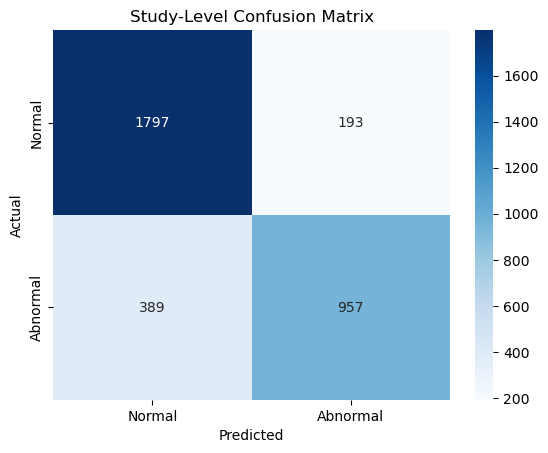

Actual: 1, Predicted Probability: 0.5339, Predicted Label: 1
Actual: 1, Predicted Probability: 0.7943, Predicted Label: 1
Actual: 1, Predicted Probability: 0.9680, Predicted Label: 1
Actual: 0, Predicted Probability: 0.2380, Predicted Label: 0
Actual: 1, Predicted Probability: 0.3889, Predicted Label: 0
Actual: 0, Predicted Probability: 0.1771, Predicted Label: 0
Actual: 1, Predicted Probability: 0.2847, Predicted Label: 0
Actual: 0, Predicted Probability: 0.0807, Predicted Label: 0
Actual: 0, Predicted Probability: 0.3727, Predicted Label: 0
Actual: 1, Predicted Probability: 0.3751, Predicted Label: 0
Actual: 0, Predicted Probability: 0.0918, Predicted Label: 0
Actual: 1, Predicted Probability: 0.8211, Predicted Label: 1
Actual: 0, Predicted Probability: 0.3138, Predicted Label: 0
Actual: 1, Predicted Probability: 0.9616, Predicted Label: 1
Actual: 0, Predicted Probability: 0.1010, Predicted Label: 0
Actual: 1, Predicted Probability: 0.1108, Predicted Label: 0
Actual: 0, Predicted Pro

In [5]:
# Confusion Matrix
cm = confusion_matrix(true_labels, binary_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Study-Level Confusion Matrix")
plt.show()

# Display Some Results (First 10 Studies)
study_ids_unique = list(study_pred_dict.keys())[:20]
for i, study_id in enumerate(study_ids_unique):
    print(f"Actual: {true_labels[i]}, Predicted Probability: {final_preds[i]:.4f}, Predicted Label: {binary_preds[i]}")
    

In [6]:
# Update the import statement at the top of your script
from sklearn.metrics import roc_auc_score, cohen_kappa_score, recall_score, precision_score

# After computing binary_preds and true_labels in your existing code
# (This is already done in your script as shown below)
# binary_preds = [1 if p > 0.5 else 0 for p in final_preds]
# true_labels = [computed from study_label_dict]

# Calculate recall and precision
recall = recall_score(true_labels, binary_preds, pos_label=1, zero_division=0)
precision = precision_score(true_labels, binary_preds, pos_label=1, zero_division=0)

# Print the results alongside other metrics
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

Recall: 0.7110
Precision: 0.8322
